# Titanic - Machine Learning from Disaster

In this notebook, we're going to analyse the famous Titanic dataset from Kaggle (https://www.kaggle.com/c/titanic/data). 

In the previous notebook, we casually explored the data and identified some intriguing correlations.

Creating a clear and structured approach is key to efficiently processing and transforming variables for use in a machine learning algorithm. Along the way, we'll also engineer additional features to enhance the model's performance. 

We'll explore techniques to handle text variables like passenger names and integrate this information into our model effectively. To maintain clarity, we'll break our code into separate functions.

Before we dive in, let's define a print function that will help us assert whether a feature has been processed or not. This will aid in tracking our progress and ensuring that each step is completed systematically.

In [1]:
# Loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def status(feature):
    print('Processing', feature, ': ok')


#### Loading the data

A common strategy when initiating a machine learning task is to concatenate the training set with the test set. By engineering new features using only the training set, we can avoid information leakage. Subsequently, we'll append these engineered variables to the test set as well.

Let's proceed by loading the train and test sets and concatenating them together.

In [3]:
def load_and_combine_data():
    # Load training data
    train_data = pd.read_csv('./data/train.csv')
    
    # Load testing data
    test_data = pd.read_csv('./data/test.csv')

    # Extract and remove the target variable from the training data
    target_variable = train_data.Survived
    train_data.drop(['Survived'], axis=1, inplace=True)
    
    # Combine training and testing data for future feature engineering
    # Also, remove 'PassengerId' as it's not a useful feature
    combined_data = pd.concat([train_data, test_data], ignore_index=True)
    combined_data.reset_index(inplace=True)
    combined_data.drop(['index', 'PassengerId'], axis=1, inplace=True)
    
    return combined_data

In [4]:
df = load_and_combine_data()

In [5]:
print(df.shape)


(1309, 10)


The total number of rows (1309) is the exact summation of the number of rows in the train set and the test set.

In [6]:
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2 - Feature engineering

### 2.1 - Extracting the passenger titles

When examining passenger names, you'll notice that each name includes a title. These titles range from simple ones like "Miss." or "Mrs." to more sophisticated ones like "Master," "Sir," or "Dona." 

Introducing an additional piece of information about the social status by parsing the name and extracting the title could be valuable. We can convert this extracted title into a binary variable.

Let's explore how we can achieve this in the function below. 

First, let's identify the different titles present in the train set.

In [7]:
#  Create a set of titles by splitting each name on ',' and '.', stripping leading and trailing whitespace, and adding the result to the set.

titles = {name.split(',')[1].split('.')[0].strip() for name in df['Name']}

In [8]:
print(titles)

{'Master', 'Mr', 'Dona', 'Col', 'Mme', 'Mlle', 'Capt', 'Lady', 'Don', 'the Countess', 'Miss', 'Ms', 'Jonkheer', 'Major', 'Mrs', 'Rev', 'Sir', 'Dr'}


In [9]:
Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

def get_titles():
    # we extract the title from each name
    df['Title'] = df['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    
    # a map of more aggregated title
    # we map each title
    df['Title'] = df.Title.map(Title_Dictionary)
    status('Title')
    return df

In [10]:
df = get_titles()

Processing Title : ok


In [11]:
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [12]:
df[df['Title'].isnull()]


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
1305,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9,C105,C,NaN


### 2.2 - Processing ages

In the initial exploration, we discovered that the "Age" variable was missing 177 values, which accounts for approximately 13% of the dataset. Simply replacing these missing values with the mean or median age might not be the most effective solution, as ages can vary significantly across different groups and categories of passengers.

To gain a better understanding, we'll group our dataset by sex, title, and passenger class. For each subset, we'll calculate the median age.

To prevent data leakage from the test set, we'll fill in missing ages in the training set using values calculated exclusively from the training set. Similarly, we'll fill in ages in the test set using values derived from the training set.

Let's begin by determining the number of missing ages in the training set.

In [13]:
df.iloc[:891].Age.isnull().sum()

177

In [14]:
df.iloc[891:].Age.isnull().sum()

86

In [15]:
grouped_train = df.iloc[:891].groupby(['Sex','Pclass','Title'])
grouped_median_train = grouped_train['Age'].median()
grouped_median_train = grouped_median_train.reset_index()

In [16]:
grouped_median_train.head()


,Sex,Pclass,Title,Age
0,female,1,Miss,30.0
1,female,1,Mrs,40.0
2,female,1,Officer,49.0
3,female,1,Royalty,40.5
4,female,2,Miss,24.0



Understanding how the median age varies based on different combinations of Sex, Pclass, and Title is crucial for imputing missing age values effectively.

For instance:

If the passenger is female, from Pclass 1, and holds a royalty title, the median age is 40.5.
If the passenger is female, from Pclass 2, with a Miss title, the median age is 24.
We'll create a function that fills in the missing age in the combined dataset based on these attributes. This function will use the median age values calculated from the training set to ensure consistency and prevent data leakage from the test set.

In [17]:
def fill_age(row):
    condition = (
        (grouped_median_train['Sex'] == row['Sex']) & 
        (grouped_median_train['Title'] == row['Title']) & 
        (grouped_median_train['Pclass'] == row['Pclass'])
    ) 
    return grouped_median_train[condition]['Age'].values[0]


def process_age():
    global df
    # a function that fills the missing values of the Age variable
    df['Age'] = df.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
    status('age')
    return df

In [18]:
df = process_age()

Processing age : ok


In [19]:
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [20]:
df['Age'].isna().sum()

0

### 2.3 - Processing names

This function  then drops the Name column since we've already created a Title column. Finally, it encodes the Title values using dummy encoding to prepare the data for machine learning algorithms.

In [21]:
def process_names():
    global df
    # we clean the Name variable
    df.drop('Name', axis=1, inplace=True)
    
    # encoding in dummy variable
    titles_dummies = pd.get_dummies(df['Title'], prefix='Title')
    titles_dummies = titles_dummies.astype(int)
    df = pd.concat([df, titles_dummies], axis=1)
    
    # removing the title variable
    df.drop('Title', axis=1, inplace=True)
    
    status('names')
    return df

In [22]:
df = process_names()

Processing names : ok


In [23]:
df.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1,0,0,0
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,0,0,0,1,0,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,0,0,0,0
3,1,female,35.0,1,0,113803,53.1000,C123,S,0,0,0,1,0,0
4,3,male,35.0,0,0,373450,8.0500,NaN,S,0,0,1,0,0,0


### 2.4 - Processing fare

Let's replace the missing fare values with the mean fare computed from the training set

In [24]:
def process_fares():
    global df
    # there's one missing fare value - replacing it with the mean.
    df.Fare.fillna(df.iloc[:891].Fare.mean(), inplace=True)
    status('fare')
    return df

In [25]:
df = process_fares()

Processing fare : ok


C:\Users\mar27\AppData\Local\Temp\ipykernel_18800\3746791302.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.Fare.fillna(df.iloc[:891].Fare.mean(), inplace=True)


### 2.5 - Processing embarked

In [26]:
def process_embarked_data(df):
    # Fill missing 'Embarked' values with the most frequent one ('S')
    df['Embarked'].fillna('S', inplace=True)
    
    # Create dummy variables for 'Embarked'
    embarked_dummies = pd.get_dummies(df['Embarked'], prefix='Embarked')
    embarked_dummies = embarked_dummies.astype(int)
    df = pd.concat([df, embarked_dummies], axis=1)
    
    # Drop the 'Embarked' column
    df.drop('Embarked', axis=1, inplace=True)
    
    status('embarked')
    return df

This function substitutes the two missing values of Embarked with the most common Embarked value.

In [27]:
df = process_embarked_data(df)

Processing embarked : ok


C:\Users\mar27\AppData\Local\Temp\ipykernel_18800\3797816648.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Embarked'].fillna('S', inplace=True)


In [28]:
df.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_C,Embarked_Q,Embarked_S
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,0,0,1,0,0,0,0,0,1
1,1,female,38.0,1,0,PC 17599,71.2833,C85,0,0,0,1,0,0,1,0,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1,0,0,0,0,0,0,1
3,1,female,35.0,1,0,113803,53.1000,C123,0,0,0,1,0,0,0,0,1
4,3,male,35.0,0,0,373450,8.0500,NaN,0,0,1,0,0,0,0,0,1


### 2.6 - Processing cabin

In [29]:
train_cabin = {c[0] if isinstance(c, str) else 'U' for c in df.iloc[:891]['Cabin']}
test_cabin = {c[0] if isinstance(c, str) else 'U' for c in df.iloc[891:]['Cabin']}

In [30]:
train_cabin

{'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'U'}

In [31]:
test_cabin

{'A', 'B', 'C', 'D', 'E', 'F', 'G', 'U'}

In [32]:
def process_cabin_data(df):
    # Fill missing 'Cabin' values with 'U' (for Unknown)
    df['Cabin'].fillna('U', inplace=True)
    
    # Map each 'Cabin' value to the first letter
    df['Cabin'] = df['Cabin'].map(lambda c: c[0])
    
    # Create dummy variables for 'Cabin'
    cabin_dummies = pd.get_dummies(df['Cabin'], prefix='Cabin')
    cabin_dummies = cabin_dummies.astype(int)
    df = pd.concat([df, cabin_dummies], axis=1)
    
    # Drop the 'Cabin' column
    df.drop('Cabin', axis=1, inplace=True)
    
    status('cabin')
    return df

This function replaces NaN values with "U" (for unknown). It then extracts the first letter from each Cabin value and encodes them using dummy encoding.

In [33]:
df = process_cabin_data(df)


C:\Users\mar27\AppData\Local\Temp\ipykernel_18800\4185649191.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Cabin'].fillna('U', inplace=True)


Processing cabin : ok


In [34]:
df.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Title_Master,Title_Miss,Title_Mr,...,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,3,male,22.0,1,0,A/5 21171,7.2500,0,0,1,...,1,0,0,0,0,0,0,0,0,1
1,1,female,38.0,1,0,PC 17599,71.2833,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,0,1,0,...,1,0,0,0,0,0,0,0,0,1
3,1,female,35.0,1,0,113803,53.1000,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,3,male,35.0,0,0,373450,8.0500,0,0,1,...,1,0,0,0,0,0,0,0,0,1


### 2.7 - Processing sex

This function converts the string values "male" and "female" to 1 and 0, respectively.

In [35]:
def process_sex_data(df):
    # Map 'Sex' values to numerical values
    df['Sex'] = df['Sex'].map({'male':1, 'female':0})
    
    status('Sex')
    return df

In [36]:
df = process_sex_data(df)


Processing Sex : ok


### 2.8 - Processing Pclass

In [37]:
def process_pclass_data(df):
    # Create dummy variables for 'Pclass'
    pclass_dummies = pd.get_dummies(df['Pclass'], prefix="Pclass")
    pclass_dummies = pclass_dummies.astype(int)

    # Add dummy variables to DataFrame
    df = pd.concat([df, pclass_dummies], axis=1)

    # Drop 'Pclass' column
    df.drop('Pclass', axis=1, inplace=True)
    
    status('Pclass')
    return df

This function performs dummy encoding on the values of Pclass (1, 2, 3).

In [38]:
df = process_pclass_data(df)


Processing Pclass : ok


### 2.9 - Processing Tickets

First, let's examine the various ticket prefixes present in our dataset.

In [39]:
def clean_ticket(ticket):
    ticket = ticket.replace('.', '').replace('/', '')
    ticket = [t.strip() for t in ticket.split()]
    ticket = [t for t in ticket if not t.isdigit()]
    return next((t for t in ticket), 'XXX')

In [40]:
tickets = {clean_ticket(t) for t in df['Ticket']}

In [41]:
len(tickets)

37

In [42]:
def process_ticket_data(df):
    # Function to clean ticket
    def clean_ticket(ticket):
        ticket = ticket.replace('.', '').replace('/', '')
        ticket = [t.strip() for t in ticket.split()]
        ticket = [t for t in ticket if not t.isdigit()]
        return next((t for t in ticket), 'XXX')

    # Clean 'Ticket' column
    df['Ticket'] = df['Ticket'].map(clean_ticket)
    
    # Create dummy variables for 'Ticket'
    tickets_dummies = pd.get_dummies(df['Ticket'], prefix='Ticket')
    tickets_dummies = tickets_dummies.astype(int)
    df = pd.concat([df, tickets_dummies], axis=1)
    
    # Drop 'Ticket' column
    df.drop('Ticket', inplace=True, axis=1)
    
    status('Ticket')
    return df

In [43]:
df = process_ticket_data(df)

Processing Ticket : ok


In [44]:
df.head()

,Sex,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,...,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX
0,1,22.0,1,0,7.2500,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,38.0,1,0,71.2833,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,26.0,0,0,7.9250,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,35.0,1,0,53.1000,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,1,35.0,0,0,8.0500,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


### 2.10 - Processing Family

In this section, we'll create new variables based on the size of the family (which, by the way, is another variable we'll create).

We'll proceed with the realistic assumption that large families are grouped together, making them more likely to get rescued than individuals traveling alone.

In [45]:
def process_family_data(df):
    # Create new feature 'FamilySize'
    df['FamilySize'] = df['Parch'] + df['SibSp'] + 1
    
    # Create other features based on the family size
    df['Singleton'] = df['FamilySize'].apply(lambda s: 1 if s == 1 else 0)
    df['SmallFamily'] = df['FamilySize'].apply(lambda s: 1 if 2 <= s <= 4 else 0)
    df['LargeFamily'] = df['FamilySize'].apply(lambda s: 1 if 5 <= s else 0)
    
    status('family')
    return df

This function introduces four new features:

* FamilySize: Represents the total number of relatives including the passenger themselves.
* Singleton: A boolean variable indicating families with a size of 1.
* SmallFamily: A boolean variable indicating families with a size between 2 and 4 (inclusive).
* LargeFamily: A boolean variable indicating families with a size greater than 5.

In [46]:
df = process_family_data(df)

Processing family : ok


In [47]:
df.shape

(1309, 67)

In the end, we'll have a total of 67 features.

In [48]:
df.head()

,Sex,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,...,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX,FamilySize,Singleton,SmallFamily,LargeFamily
0,1,22.0,1,0,7.2500,0,0,1,0,0,...,0,0,0,0,0,0,2,0,1,0
1,0,38.0,1,0,71.2833,0,0,0,1,0,...,0,0,0,0,0,0,2,0,1,0
2,0,26.0,0,0,7.9250,0,1,0,0,0,...,1,0,0,0,0,0,1,1,0,0
3,0,35.0,1,0,53.1000,0,0,0,1,0,...,0,0,0,0,0,1,2,0,1,0
4,1,35.0,0,0,8.0500,0,0,1,0,0,...,0,0,0,0,0,1,1,1,0,0


## 3 - Modeling

In this section, we leverage our understanding of the passengers, based on the features we've created, to construct a statistical model.

Now, we need to:

    1. Split the combined dataset into a training set and a test set.
    2. Utilize the training set to construct a predictive model.
    3. Assess the model's performance using the training set.
    4. Validate the model's performance using the test set and generate an output file.

In [49]:
## Loading libraries 

from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

To evaluate our model, we'll employ a 5-fold cross-validation approach using accuracy as the metric, which aligns with the Kaggle competition's leaderboard.

To facilitate this, we'll define a simple scoring function.

In [50]:
def compute_cross_val_score(classifier, features, labels, scoring_method='accuracy'):
    cross_val_scores = cross_val_score(classifier, features, labels, cv=5, scoring=scoring_method)
    return np.mean(cross_val_scores)

Retrieving the train set and the test set from the combined dataset is straightforward.

In [51]:
def recover_train_test_target_data(df):
    targets = pd.read_csv('./data/train.csv', usecols=['Survived'])['Survived'].values
    train_data = df.iloc[:891]
    test_data = df.iloc[891:]
    
    return train_data, test_data, targets

In [52]:
train, test, targets = recover_train_test_target_data(df)

In [53]:
train.head()

,Sex,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,...,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX,FamilySize,Singleton,SmallFamily,LargeFamily
0,1,22.0,1,0,7.2500,0,0,1,0,0,...,0,0,0,0,0,0,2,0,1,0
1,0,38.0,1,0,71.2833,0,0,0,1,0,...,0,0,0,0,0,0,2,0,1,0
2,0,26.0,0,0,7.9250,0,1,0,0,0,...,1,0,0,0,0,0,1,1,0,0
3,0,35.0,1,0,53.1000,0,0,0,1,0,...,0,0,0,0,0,1,2,0,1,0
4,1,35.0,0,0,8.0500,0,0,1,0,0,...,0,0,0,0,0,1,1,1,0,0


In [54]:
train.shape

(891, 67)

In [55]:
test.head()

,Sex,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,...,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX,FamilySize,Singleton,SmallFamily,LargeFamily
891,1,34.5,0,0,7.8292,0,0,1,0,0,...,0,0,0,0,0,1,1,1,0,0
892,0,47.0,1,0,7.0000,0,0,0,1,0,...,0,0,0,0,0,1,2,0,1,0
893,1,62.0,0,0,9.6875,0,0,1,0,0,...,0,0,0,0,0,1,1,1,0,0
894,1,27.0,0,0,8.6625,0,0,1,0,0,...,0,0,0,0,0,1,1,1,0,0
895,0,22.0,1,1,12.2875,0,0,0,1,0,...,0,0,0,0,0,1,3,0,1,0


In [56]:
test.shape

(418, 67)

In [57]:
targets


array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,

### 3.1 - Feature selection

We've accumulated over 30 features thus far, which is quite a substantial number. However, it's common practice in feature engineering to reduce dimensionality by selecting the optimal number of features that capture the essential information.

Feature selection offers several benefits:

- It reduces redundancy in the data.
- It accelerates the training process.
- It mitigates the risk of overfitting.

_Tree-based estimators_ are particularly useful for computing feature importances, which can then guide the elimination of irrelevant features.

In [58]:
# Instantiate a Random Forest Classifier with 50 estimators and 'sqrt' as the max features parameter
rf_classifier = RandomForestClassifier(n_estimators=50, max_features='sqrt')

# Fit the classifier to the training data and targets
rf_classifier = rf_classifier.fit(train, targets)

In [59]:
# Create a DataFrame with the feature names and their importances
features = pd.DataFrame({
    'feature': train.columns,
    'importance': rf_classifier.feature_importances_
})

# Sort the DataFrame by the importance of the features in ascending order
features.sort_values(by='importance', ascending=True, inplace=True)

# Set the index of the DataFrame to be the feature names
features.set_index('feature', inplace=True)

_The 'feature importances' attribute in the RandomForestClassifier is a function that computes the importance of each feature (variable) in the model. Feature importance gives you a score for each feature of your data, the higher the score more important or relevant is the feature towards your output variable._

_The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance._

_Random Forest performs a series of decisions based on the values of the features. The importance of each feature is determined by how much each feature decreases the weighted impurity in a tree. For a forest, the impurity decrease from each feature can be averaged and the features are ranked according to this measure._

<AxesSubplot: ylabel='feature'>

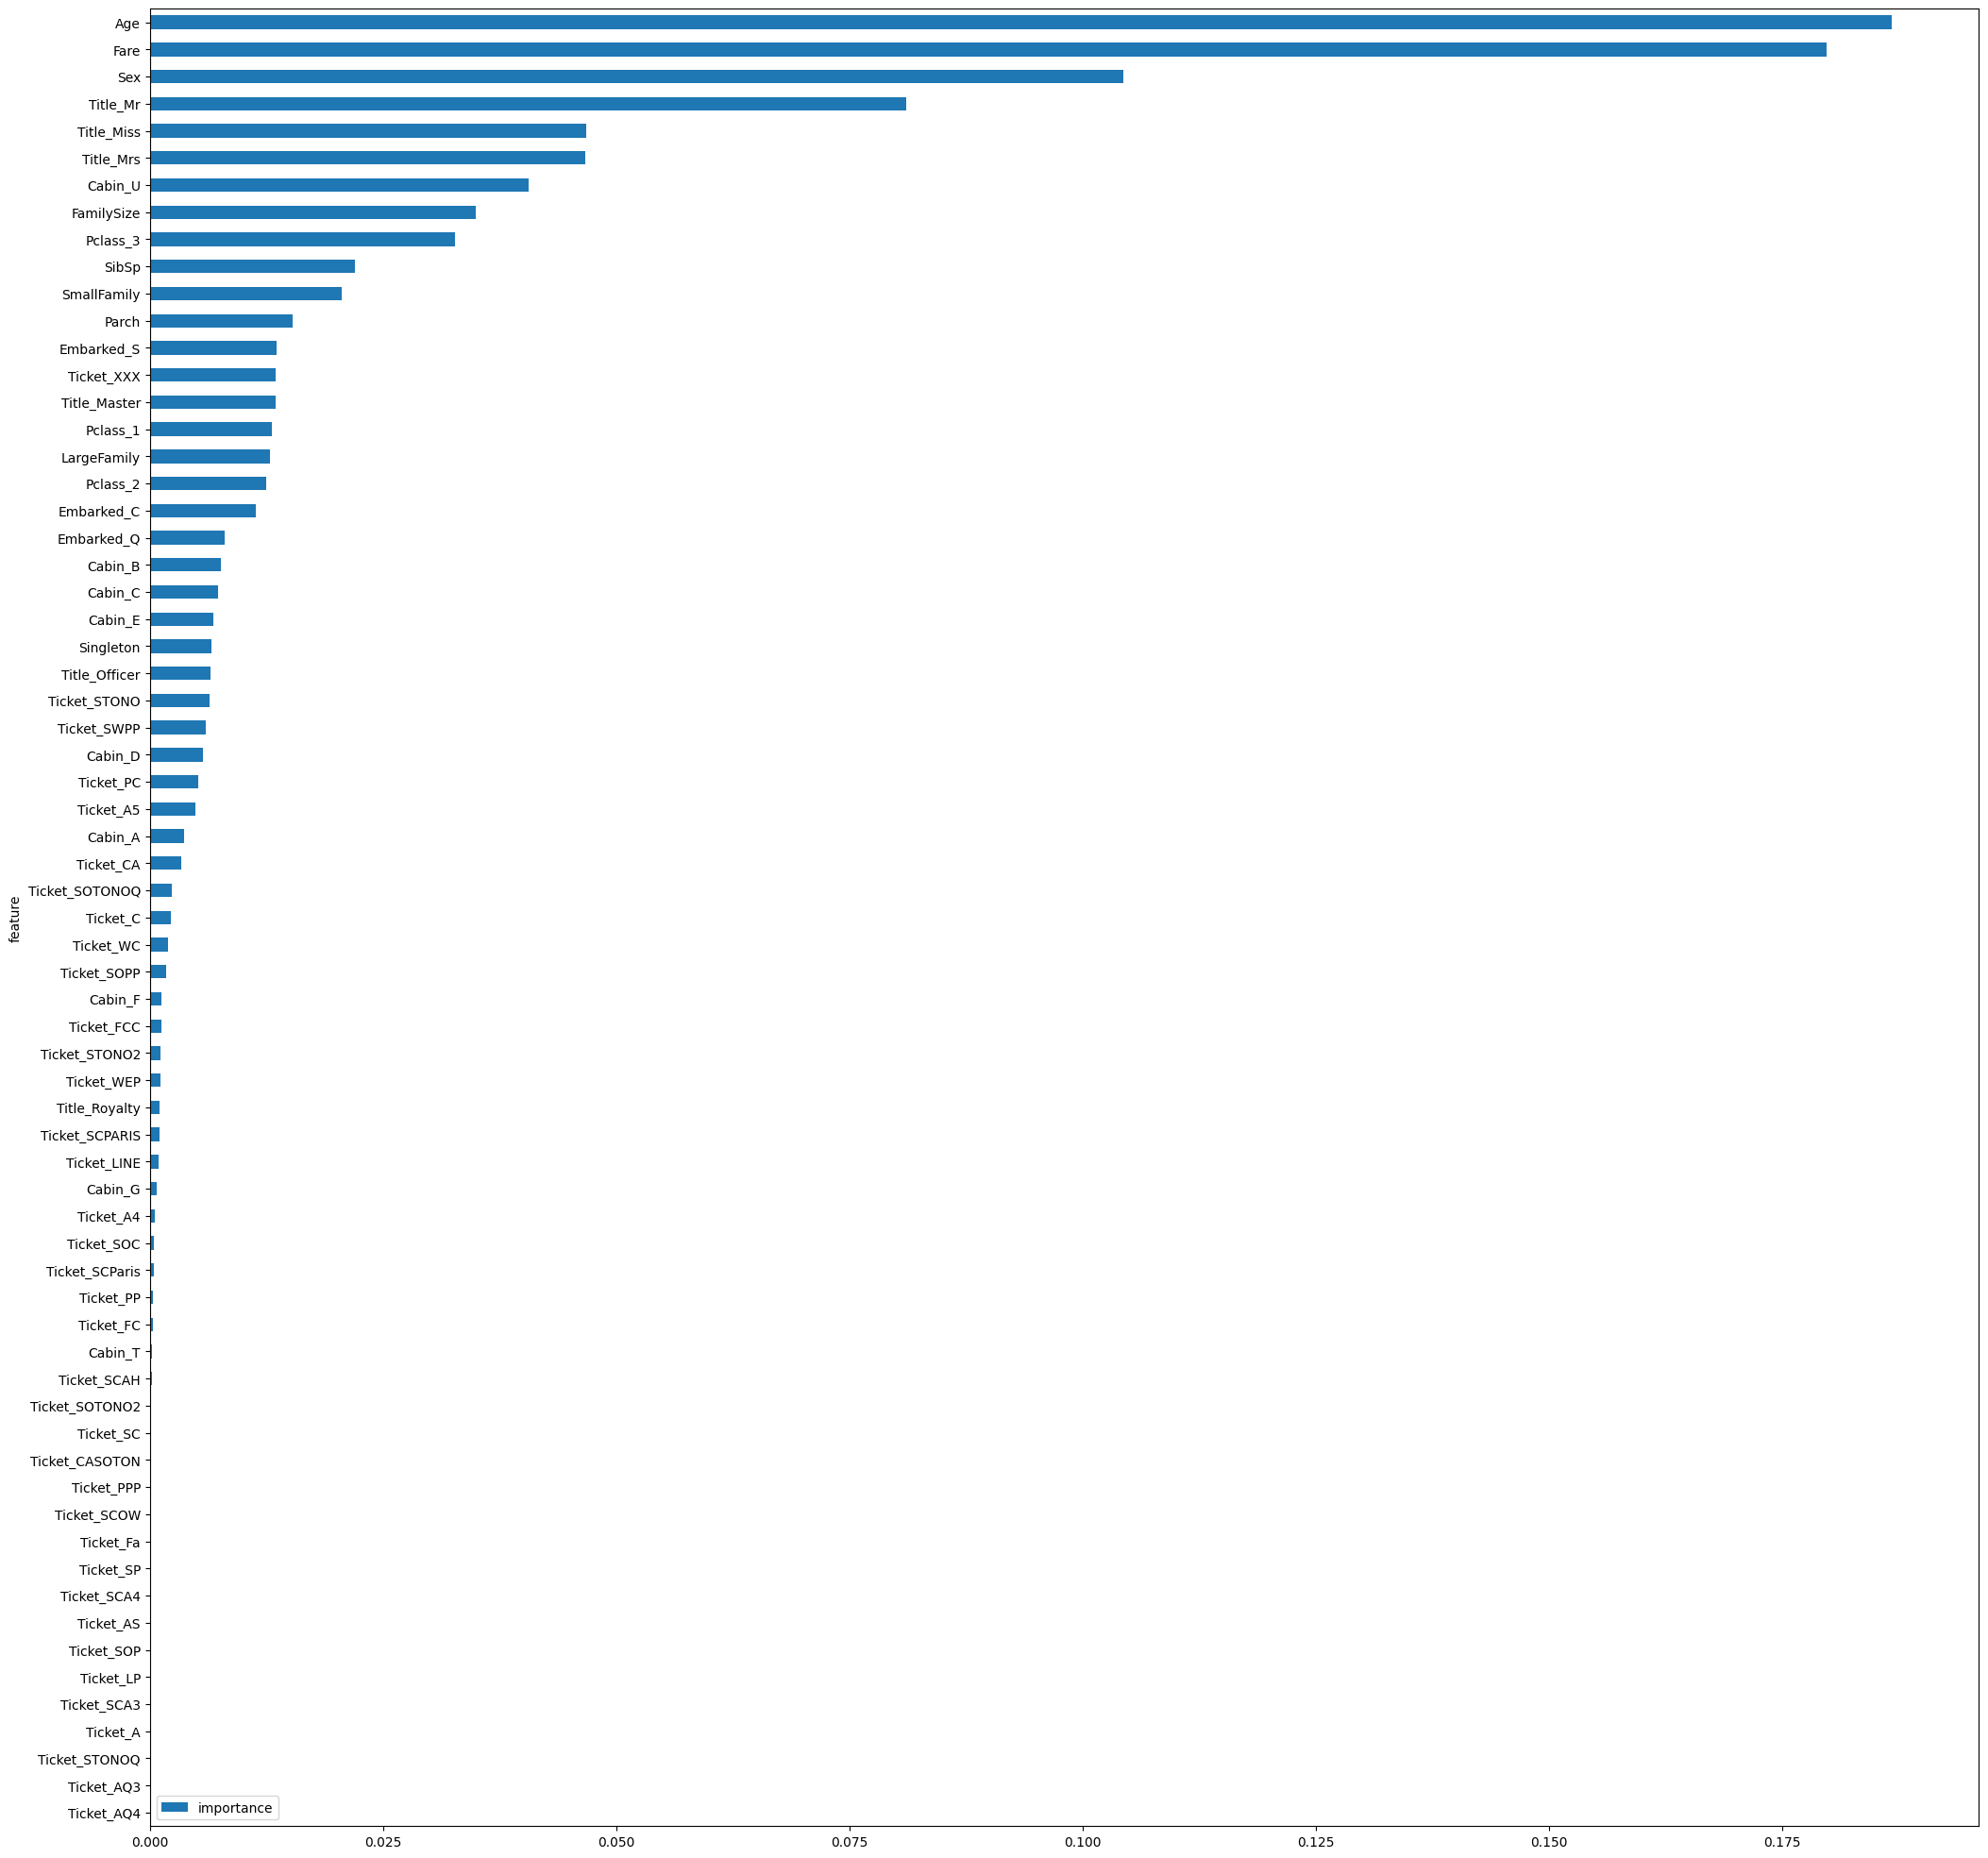

In [60]:
# Plot the feature importances in a horizontal bar chart
# 'figsize' parameter is used to specify the size of the figure in inches
features.plot(kind='barh', figsize=(25, 25))

As you've observed, certain features such as Title_Mr, Age, Fare, Sex, and even Passenger_Id exhibit significant importance and correlations within the dataset.

To streamline our analysis, let's transform both the train set and test set into more compact datasets.

In [61]:
# Instantiate a SelectFromModel object with the pre-trained classifier
# 'prefit=True' means that the model is already trained
model = SelectFromModel(rf_classifier, prefit=True)

# Transform the training data to retain only the most important features
# This is done based on the feature importances from the classifier
train_reduced = model.transform(train)

# Print the shape of the reduced training data
# This shows the number of features retained
print(train_reduced.shape)

(891, 12)


C:\Users\mar27\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [62]:
# Transform the testing data to retain only the most important features
# This is done based on the feature importances from the classifier
test_reduced = model.transform(test)

# Print the shape of the reduced testing data
# This shows the number of features retained
print(test_reduced.shape)

(418, 12)


C:\Users\mar27\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Great! We've successfully reduced the number of features from 67 to 12.

Now, we'll decide whether to proceed with the reduced version or the full version of the train set for further analysis.

### 3.2 - Trying different base models

In [63]:
# Instantiate a Logistic Regression model
logistic_regression = LogisticRegression()

# Instantiate a Logistic Regression model with Cross-Validation
logistic_regression_cv = LogisticRegressionCV()

# Instantiate a Random Forest Classifier
random_forest = RandomForestClassifier()

# Instantiate a Gradient Boosting Classifier
gradient_boosting = GradientBoostingClassifier()

# Create a list of all the models
models = [logistic_regression, logistic_regression_cv, random_forest, gradient_boosting]

In [69]:
# Iterate over each model in the models list
for model in models:
    # Print the class name of the model
    print(f'Cross-validation of : {model}')
    
    # Compute the cross-validation score of the model on the reduced training data and targets
    # The scoring method is accuracy
    cval_score = compute_cross_val_score(classifier=model, features=train_reduced, labels=targets, scoring_method='accuracy')
    
    # Print the cross-validation score
    print(f'CV score = {cval_score}')
    
    # Print separator
    print('****')

Cross-validation of : LogisticRegression()
CV score = 0.8192894356914193
****
Cross-validation of : LogisticRegressionCV()


C:\Users\mar27\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\mar27\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

CV score = 0.8226602222082731
****
Cross-validation of : RandomForestClassifier()
CV score = 0.8226727763480008
****
Cross-validation of : GradientBoostingClassifier()
CV score = 0.8282656455966355
****


#### Hyperparameters tuning for Random forest

Random Forests are versatile models, but they do require tuning of certain parameters to achieve optimal performance for the prediction task.

We'll proceed with using the full train set.

In [65]:
# Set run_gs to True if you want to run the grid search again
run_grid_search = False

if run_grid_search:
    # Define the parameter grid for the grid search
    parameter_grid = {
        'max_depth': [4, 6, 8],
        'n_estimators': [50, 10],
        'max_features': ['sqrt', 'auto', 'log2'],
        'min_samples_split': [2, 3, 10],
        'min_samples_leaf': [1, 3, 10],
        'bootstrap': [True, False],
    }
    
    # Instantiate a Random Forest Classifier
    random_forest = RandomForestClassifier()
    
    # Define the cross-validation strategy for the grid search
    cross_validation = StratifiedKFold(n_splits=5)
    
    # Instantiate a GridSearchCV object with the Random Forest Classifier, the parameter grid, and the cross-validation strategy
    grid_search = GridSearchCV(
        random_forest,
        scoring='accuracy',
        param_grid=parameter_grid,
        cv=cross_validation,
        verbose=1
    )
    
    # Fit the GridSearchCV object to the training data and targets
    grid_search.fit(train, targets)
    
    # Set the best model found by the grid search as the model to use
    model = grid_search
    
    # Get the best parameters found by the grid search
    best_parameters = grid_search.best_params_
    
    # Print the best score and parameters found by the grid search
    print(f'Best score: {grid_search.best_score_}')
    print(f'Best parameters: {grid_search.best_params_}')
    
else:
    # Define the parameters to use if not running the grid search
    parameters = {
        'bootstrap': False,
        'min_samples_leaf': 3,
        'n_estimators': 50,
        'min_samples_split': 10,
        'max_features': 'sqrt',
        'max_depth': 6
    }
    
    # Instantiate a Random Forest Classifier with the defined parameters
    model = RandomForestClassifier(**parameters)
    
    # Fit the Random Forest Classifier to the training data and targets
    model.fit(train, targets)

We can generate an output file to submit on Kaggle.

In [66]:
# Use the model to predict the targets for the test data
# The predictions are converted to integers using astype(int)
predictions = model.predict(test).astype(int)

# Create an empty DataFrame to store the output
output_dataframe = pd.DataFrame()

# Read the test data file to get the 'PassengerId' column
auxiliary = pd.read_csv('./data/test.csv')

# Add the 'PassengerId' column to the output DataFrame
output_dataframe['PassengerId'] = auxiliary['PassengerId']

# Add the predictions as the 'Survived' column in the output DataFrame
output_dataframe['Survived'] = predictions

# Write the 'PassengerId' and 'Survived' columns of the output DataFrame to a CSV file
# 'index=False' means that the index will not be written to the file
output_dataframe[['PassengerId', 'Survived']].to_csv('./gridsearch_rf.csv', index=False)

In [68]:
results = pd.read_csv('./gridsearch_rf.csv')
results.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


### 3.3 - Gradient Booted trees

In [70]:
# Set run_gs to True if you want to run the grid search again
run_grid_search = False

if run_grid_search:
    # Define the parameter grid for the grid search
    parameter_grid = {
        'max_depth': [4, 6, 8],
        'n_estimators': [50, 10],
        'max_features': ['sqrt', 'auto', 'log2'],
        'min_samples_split': [2, 3, 10],
        'min_samples_leaf': [1, 3, 10],
    }
    
    # Instantiate a Gradient Boosting Classifier
    gradient_boosting = GradientBoostingClassifier()
    
    # Define the cross-validation strategy for the grid search
    cross_validation = StratifiedKFold(n_splits=5)
    
    # Instantiate a GridSearchCV object with the Gradient Boosting Classifier, the parameter grid, and the cross-validation strategy
    grid_search = GridSearchCV(
        gradient_boosting,
        scoring='accuracy',
        param_grid=parameter_grid,
        cv=cross_validation,
        verbose=1
    )
    
    # Fit the GridSearchCV object to the training data and targets
    grid_search.fit(train, targets)
    
    # Set the best model found by the grid search as the model to use
    model = grid_search
    
    # Get the best parameters found by the grid search
    best_parameters = grid_search.best_params_
    
    # Print the best score and parameters found by the grid search
    print(f'Best score: {grid_search.best_score_}')
    print(f'Best parameters: {grid_search.best_params_}')
    
else:
    # Define the parameters to use if not running the grid search
    parameters = {
        'min_samples_leaf': 3,
        'n_estimators': 50,
        'min_samples_split': 10,
        'max_features': 'sqrt',
        'max_depth': 6
    }
    
    # Instantiate a Gradient Boosting Classifier with the defined parameters
    model = GradientBoostingClassifier(**parameters)
    
    # Fit the Gradient Boosting Classifier to the training data and targets
    model.fit(train, targets)

In [71]:
# Use the model to predict the targets for the test data
# The predictions are converted to integers using astype(int)
predictions = model.predict(test).astype(int)

# Create an empty DataFrame to store the output
output_dataframe = pd.DataFrame()

# Read the test data file to get the 'PassengerId' column
auxiliary = pd.read_csv('./data/test.csv')

# Add the 'PassengerId' column to the output DataFrame
output_dataframe['PassengerId'] = auxiliary['PassengerId']

# Add the predictions as the 'Survived' column in the output DataFrame
output_dataframe['Survived'] = predictions

# Write the 'PassengerId' and 'Survived' columns of the output DataFrame to a CSV file
# 'index=False' means that the index will not be written to the file
output_dataframe[['PassengerId', 'Survived']].to_csv('./gridsearch_gb.csv', index=False)

In [72]:
results = pd.read_csv('./gridsearch_gb.csv')
results.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


## 4 - Conclusions

In this article, we delved into an intriguing dataset provided by Kaggle. We navigated through the fundamental components of a data science pipeline:

1. Data exploration and visualization: An initial step to formulate hypotheses (first notebook).
2. Data cleaning.
3. Feature engineering.
4. Feature selection.
5. Hyperparameter tuning.
6. Submission.

While this article covers a lot, there's always room for improvement. Here are some suggested next steps:

1. Delve deeper into the data and potentially create new features.
2. Experiment with different models such as logistic regressions, XGBoost, etc.
3. Explore ensemble learning techniques like stacking.
4. Utilize auto-ML frameworks to streamline the model selection process.